In [1]:
from multiview.datasets.base import load_UCImultifeature
from multiview.cluster.mv_k_means import MultiviewKMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI

In [2]:
help(load_UCImultifeature)

Help on function load_UCImultifeature in module multiview.datasets.base:

load_UCImultifeature(select_labeled='all')
    Load the UCI multiple features dataset, taken from
    https://archive.ics.uci.edu/ml/datasets/Multiple+Features
    This data set consists of 6 views of handwritten digit images, with
    classes 0-9. The 6 views are the following:
    
    1. 76 Fourier coefficients of the character shapes
    2. 216 profile correlations
    3. 64 Karhunen-Love coefficients
    4. 240 pixel averages of the images from 2x3 windows
    5. 47 Zernike moments
    6. 6 morphological features
    
    Each class contains 200 labeled examples.
    
    Parameters
    ----------
    select_labeled : optional, array-like, shape (n_features,) default (all)
        A list of the examples that the user wants by label. If not
        specified, all examples in the dataset are returned. Repeated labels
        are ignored.
    
    Returns
    -------
    data : list of np.ndarray, each of size 

### Load in UCI multiple feature dataset as an example

In [3]:
# Load dataset along with labels
n_class = 5
data, labels = load_UCImultifeature(select_labeled = list(range(n_class)))

# Isolate the first two views of the data
m_data = [data[0], data[1]]

# Obtain the single view data through column-wise concatenation of both views
s_data = np.hstack(m_data)

### Comparing performance of single-view kmeans clustering against multi-view kmeans clustering for a single value of k

In [4]:
#Function for computing entropy of labels across clusters
def compute_entropy(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        if(part_size == 0):
            part_size = 1
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

In [5]:
#Single-view kmeans clustering
s_kmeans = KMeans(n_clusters = n_class)
s_clusters = s_kmeans.fit_predict(s_data)
s_nmi = NMI(s_clusters, labels)
print('Single-view nmi score is ' + str(s_nmi))

#Multi-view kmeans clustering
m_kmeans = MultiviewKMeans(k = n_class)
m_clusters = m_kmeans.fit_predict(m_data)
m_nmi = NMI(m_clusters, labels)
print('Multi-view nmi score is ' + str(m_nmi))

print('Single-view entropy is ' 
      + str(compute_entropy(s_clusters, labels, n_class, n_class)))
print('Multi-view entropy is ' 
      + str(compute_entropy(m_clusters, labels, n_class, n_class)))

Single-view nmi score is 0.7475050541468636
Multi-view nmi score is 0.7776423293237318
Single-view entropy is 0.5881521402482025
Multi-view entropy is 0.5181122185410776


### Comparing performance of single-view kmeans clustering against multi-view kmeans clustering across a range of k values

In [6]:
#Average performance metrics over 100 trials
num_trials = 25

#A function for computing NMI and entropy over a range
#of k values
def eval_performance(n_views, data, labels, num_trials):
    trials_nmi = list()
    trials_ent = list()
    for ind in range(num_trials):
        nmis = list()
        ent = list()
        for k in range(1, 11):
            kmeans = None
            if (n_views == 1):
                kmeans = KMeans(k)
            else:
                kmeans = MultiviewKMeans(k) 
            clusters = kmeans.fit_predict(data)
            nmis.append(NMI(labels, clusters))
            ent.append(compute_entropy(clusters, labels, k, n_class))
        trials_nmi.append(nmis)
        trials_ent.append(ent)
    trials_nmi = np.array(trials_nmi)
    trials_nmi = np.mean(trials_nmi, axis = 0)
    trials_ent = np.array(trials_ent)
    trials_ent = np.mean(trials_ent, axis = 0)
    return trials_nmi, trials_ent

#Compute NMI and entropy of single-view kmeans clusters 
#across a range of k values
s_nmi, s_ent = eval_performance(1, s_data, labels, num_trials)
        
#Compute NMI and entropy of multi-view kmeans clusters 
#across a range of k values 
m_nmi, m_ent = eval_performance(2, m_data, labels, num_trials)


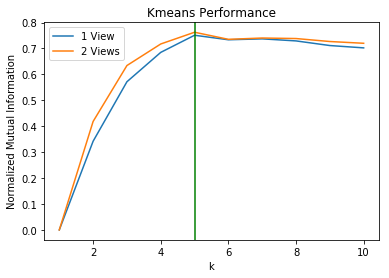

In [7]:
import matplotlib.pyplot as plt
x_values = list(range(1, 11))
plt.plot(x_values, s_nmi, x_values, m_nmi)
plt.axvline(x=5, c= 'g')
plt.xlabel('k')
plt.ylabel('Normalized Mutual Information')
plt.legend(['1 View', '2 Views'])
plt.title('Kmeans Performance')
plt.show()

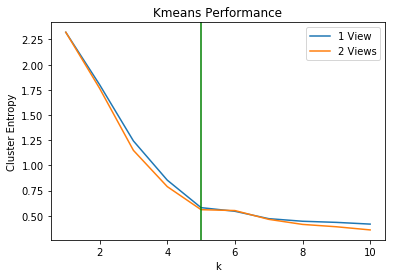

In [8]:
import matplotlib.pyplot as plt
x_values = list(range(1, 11))
plt.plot(x_values, s_ent, x_values, m_ent)
plt.axvline(x=5, c= 'g')
plt.xlabel('k')
plt.ylabel('Cluster Entropy')
plt.legend(['1 View', '2 Views'])
plt.title('Kmeans Performance')
plt.show()